In this notebook you can reproduce the simulation figures to test the PCA denoising algorithm in a 9 fiber phantom with uncorrelated noise.

Let's import the relevant modules for these simulations.

In [1]:
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
from time import time

from scipy.linalg import eigh
from scipy.ndimage import gaussian_filter

import dipy.reconst.dki as dki
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.data import get_sphere, get_fnames
from dipy.core.gradients import gradient_table
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from dipy.viz import window, actor

sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(n=2)

<frozen importlib._bootstrap>:219: RuntimeWarning: dipy.direction.pmf.PmfGen size changed, may indicate binary incompatibility. Expected 440 from C header, got 448 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: dipy.direction.pmf.SimplePmfGen size changed, may indicate binary incompatibility. Expected 440 from C header, got 448 from PyObject


The cells below contains the new parts of the code produced for this project, including:

<ins>1) Functions to assess the performance of denoising </ins>

In [2]:
def mp_distribution(x, var, y):
    """ Samples the Marchenko–Pastur probability distribution
    Parameters
    ----------
    x : array (N,)
        Values of random variable to sample the probability distribution
    var : float
        Variance of the random variable
    y : float
        Parameter associated to the matrix X that produces the distributions.
        This X is a M x N random matrix which columns entries are identical
        distributed random variables with mean 0 and given variance, y is given
        by N/M.
    """
    xpos = var * (1 + np.sqrt(y)) ** 2
    xneg = var * (1 - np.sqrt(y)) ** 2

    p = np.zeros(x.shape)
    xdis = np.logical_and(x<xpos, x>xneg)
    p[xdis] = np.sqrt((xpos-x[xdis]) * (x[xdis]-xneg)) / (2*np.pi*var*y*x[xdis])
    if np.sum(p) == 0:
        return p
    else:
        return p / np.sum(p)

    
def _pca_classifier(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    var = np.mean(L)
    c = L.size - 1
    r = L[c] - L[0] - 4 * np.sqrt((L.size) / nvoxels) * var
    while r > 0:
        var = np.mean(L[:c])
        c = c - 1
        sig_mp = (L[c] - L[0]) / (4 * np.sqrt((c + 1.0) / nvoxels)) 
        r =  sig_mp - var
    ncomps = c + 1
    return var, ncomps


def _pca_classifier_slow(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    """
    # To not make any assumptions about the expectation of the
    # number of signal compartments, let's initialize the code
    # assessing all components as being noise (this is the case of
    # background voxels)
    n = L.size
    c = n
    
    # Iterations will stop if the next number of signal components
    # was already assessed in previous iterations. This includes the
    # case c[i] = c[i+1], and also avoids infinite loops, e.g. cases
    # that c[i] = a leads to c[i+1] = b which then leads to c[i+2] = a
    # (i.e. creating a infinite loop of assessing a and b number of
    # components)
    # Given the above, let create a vector to tarked which number of
    # components were assessed.
    c_considered = np.zeros(n)

    # start loop
    # (note c-1 is used instead of c, because c is the number of components,
    # which indexes goes from 0 to c-1)
    while c_considered[c-1] == 0:
        
        # Compute optimal number of bins for the selected noise components

        nbin = np.arange(5, n)  # maximum number of bins is set to number
        # of eigenvalues, i.e. case of a number of bins larger than
        # a number of egienvalues is not considered. 
        # 5 bins are considered as the minumun reasonable 
        # number of bins.

        # procedure implemented according to Veraart et al., 2016 [1]        
        rang = L[c-1] - L[0]
        h = rang / nbin
        nb_vall = np.zeros(nbin.size)
        for ii, ni in enumerate(nbin):
            ro, bins = np.histogram(L[:c], bins=ni, range=(L[0], L[c-1]))
            ro_mean = np.mean(ro)
            ro_var = np.var(ro)
            nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)
        nb = nbin[np.argmin(nb_vall)]

        # compute final histogram to be fitted
        ro, bins = np.histogram(L[:c], bins=nb, range=(L[0], L[c-1]))
            
        # initial variance estimate
        var_in = L[0] / ((1 - np.sqrt(c / nvoxels)) ** 2)
            
        # iteratively refine variance estimate that produces
        # a theoritical distribution that fits the measured histogram
        # (for that let consider a range between half of the initial std
        # estimate and four times larger that the initial std estimate)
        sigma_grid = np.linspace(np.sqrt(var_in)/2, 4*np.sqrt(var_in), num=500)
        sigma_eval = np.zeros(sigma_grid.shape)
        for std_i, std_val in enumerate(sigma_grid):
            dist = c * mp_distribution(bins[:-1]+rang/(2*nb), std_val**2, c / nvoxels)
            notzero = dist > 0
            if np.sum(dist) == 0:
                sigma_eval[std_i] = np.inf
            else:
                sigma_eval[std_i] =  np.sum((ro[notzero] - dist[notzero]) ** 2 / dist[notzero])
        
        indmin = np.flatnonzero(sigma_eval == sigma_eval.min())
        var_out = sigma_grid[indmin[-1]] ** 2
            
        # use refined variance estimate for component classification
        tau_factor = 1 + np.sqrt(c / nvoxels)
        tau = tau_factor ** 2 * var_out
            
        # update number of noise components
        c_considered[c - 1] = 1
        c = np.sum(L < tau)

    ncomps = c
    var = np.mean(L[:c])
    return var, ncomps


def _pca_classifier_slow_plot(L, c, nvoxels, xlim=None):
    """ Plots the fitted MP distribution to the eigenvalue spectrum
    considering the c lower eigenvalues.
    
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    c : int
        number of signal components that you want to consider for
        ploting the MP fitted distribution 
    nvoxels : int
        Number of voxels used to compute L

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        New Number of eigenvalues indicated after histogram fit
    nb : int
        Number of bins automatically determined

    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    """
    n = L.size
    
    # Compute optimal number of bins for the selected noise components

    nbin = np.arange(5, n)  # maximum number of bins is set to number
    # of eigenvalues, i.e. case of a number of bins larger than
    # a number of egienvalues is not considered. 
    # 5 bins are considered as the minumun reasonable 
    # number of bins.

    # procedure implemented according to Veraart et al., 2016 [1]        
    rang = L[c-1] - L[0]
    h = rang / nbin
    nb_vall = np.zeros(nbin.size)
    for ii, ni in enumerate(nbin):
        ro, bins = np.histogram(L[:c], bins=ni, range=(L[0], L[c-1]))
        ro_mean = np.mean(ro)
        ro_var = np.var(ro)
        nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)
    nb = nbin[np.argmin(nb_vall)]

    # compute final histogram to be fitted
    ro, bins = np.histogram(L[:c], bins=nb, range=(L[0], L[c-1]))
            
    # initial variance estimate
    var_in = L[0] / ((1 - np.sqrt((c) / nvoxels)) ** 2)
    
    dist = mp_distribution(bins[:-1]+rang/(2*nb), var_in, c / nvoxels)
    if xlim is None:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.show()
    else:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.xlim(xlim)
        plt.show()
            
    # iteratively refine variance estimate that produces
    # a theoritical distribution that fits the measured histogram
    # (for that let consider a range between half of the initial std
    # estimate and four times larger that the initial std estimate)
    sigma_grid = np.linspace(np.sqrt(var_in)/2, 4*np.sqrt(var_in), num=500)
    sigma_eval = np.zeros(sigma_grid.shape)
    for std_i, std_val in enumerate(sigma_grid):
        dist = c * mp_distribution(bins[:-1]+rang/(2*nb), std_val**2, c / nvoxels)
        notzero = dist > 0
        if np.sum(dist) == 0:
            sigma_eval[std_i] = np.inf
        else:
            sigma_eval[std_i] =  np.sum((ro[dist > 0] - dist[dist > 0]) ** 2 / dist[dist > 0])
            
    plt.figure
    plt.plot(sigma_eval)
    plt.show()
    
    indmin = np.flatnonzero(sigma_eval == sigma_eval.min())
    print(indmin)
    print(indmin[-1])
    var_out = sigma_grid[indmin[-1]] ** 2
    
    dist = mp_distribution(bins[:-1]+rang/(2*nb), var_out, c / nvoxels)
    if xlim is None:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.show()
    else:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.xlim(xlim)
        plt.show()
            
    # use refined variance estimate for component classification
    tau_factor = 1 + np.sqrt(c / nvoxels)
    tau = tau_factor ** 2 * var_out
    cnew = np.sum(L < tau)

    # update number of noise components
    ncomps = cnew
    var = np.mean(L[:cnew])
    return var, ncomps, nb


def _gpca_classifier(L, varest):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. 2023
    """
    var = np.mean(L)
    c = L.size - 1
    while var > varest:
        var = np.mean(L[:c])
        c = c - 1
    ncomps = c + 1
    return var, ncomps


def _tpca_classifier(L, varest, tau_factor):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. 2023
    """
    tau = tau_factor ** 2 * varest
    ncomps = np.sum(L < tau)
    var = np.mean(L[:ncomps])

    return var, ncomps


def _pca_classifier_code(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    rang = np.zeros(L.shape)
    sig2 = np.zeros(L.shape)
    for c in range(1, L.size+1):
        var = np.mean(L[:c])
        c = c - 1
        rang[c] = L[c] - L[0] 
        #sig2[c] =  4 * np.sqrt((c + 1.0) / nvoxels) * var
        sig2[c] =  (L[c] - L[0])/(4 * np.sqrt((L.size) / nvoxels))
        sig2[c] =  (L[c] - L[0])/(4 * np.sqrt((c + 1.0) / nvoxels))
    return var, sig2


def _pca_classifier_code2(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    sig2_w = np.zeros(L.shape)
    sig2_m = np.zeros(L.shape)
    for c in range(1, L.size+1):
        var = np.mean(L[:c])  #RHS
        c = c - 1
        sig2_w[c] = (L[c] - L[0]) / (4 * np.sqrt((c + 1.0) / nvoxels))
        sig2_m[c] = var
    return sig2_m, sig2_w



def _pca_matrix(X, sig2=None, pca_method='eig', mppca_slow=False,
                tau_factor=None):
    """ Helper function to perform PCA-denoising of a 2D matrix

    Parameters
    ----------
    X : 2D array (m, n)
        2D matrix to denoise

    Returns
    -------
    Xd : 2D array (m, n)
        Denoised 2D matrix

    Notes
    -----
    If sigma is None it used MPPCA (standard or slow algorithm if
    to input variable mppca_slow is False or True respectively)
    If sigma and tau_factor is given, it used threshold approach
    If sigma is given but not tau_factor, it uses the TPCA approach
    
    """
    n = X.shape[1]
    m = X.shape[0]
    X0 = X.copy()

    if pca_method.lower() == 'svd':
        is_svd = True
    else:
        is_svd = False
    
    M = np.mean(X0, axis=0)
    X0 = X0 - M

    if is_svd:
        # PCA using an SVD
        U, S, Vt = svd(X0, *svd_args)[:3]
        # Items in S are the eigenvalues, but in ascending order
        # We invert the order (=> descending), square and normalize
        # \lambda_i = s_i^2 / n
        d = S[::-1] ** 2 / X.shape[0]
        # Rows of Vt are eigenvectors, but also in ascending
        # eigenvalue order:
        W = Vt[::-1].T

    else:
        # PCA using an Eigenvalue decomposition
        C = np.transpose(X0).dot(X0)
        C = C / X.shape[0]
        [d, W] = eigh(C, turbo=True)

    if sig2 is None:
        # Random matrix theory
        if mppca_slow:
            this_var, ncomps = _pca_classifier_slow(d, m)
        else:
            this_var, ncomps = _pca_classifier(d, m)
        
    else:
        # Predefined variance
        this_var = sig2
        if tau_factor is None:
            this_var, ncomps = _gpca_classifier(d, this_var)        
        else:
            # tau_factor = 1 + np.sqrt(n / m)
            tau = tau_factor ** 2 * this_var
            
            # Update ncomps according to tau_factor
            ncomps = np.sum(d < tau)
                

    W[:, :ncomps] = 0

    # This is equations 1 and 2 in Manjon 2013:
    Xd = X0.dot(W).dot(W.T) + M

    return Xd, ncomps
                        


<ins> 2) Functions to produce data phantom </ins>

In [3]:
def fib3_phantom_9comps(gtab, snr=None, noise_type='G', N=30):
    """Phantom with three orthogonal fibers"""

    xa = int(1/3 * N)
    
    # sampled 9 directions
    n_pts = 9
    #theta = np.pi * np.random.rand(n_pts)
    #phi = 2 * np.pi * np.random.rand(n_pts)
    #hsph_initial = HemiSphere(theta=theta, phi=phi)
    #hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    #directions = hsph_updated.vertices
    
    directions = np.array([[0.0427, 0.8323, 0.5527],
                           [-0.0328, -0.1969, -0.9799],
                           [0.7303, 0.1161, 0.6732],
                           [-0.0034, 0.5586, -0.8294],
                           [0.9991, -0.0357, -0.0242],
                           [0.0278, 0.9809, -0.1923],
                           [0.7252, 0.6711, -0.1538],
                           [0.6842, -0.1635, -0.7107],
                           [0.6860, -0.7182, 0.1171]])
    
    # define voxel index
    slice_ind = np.zeros((N, N))
    slice_ind[0:xa, 0:xa] = 0
    slice_ind[0:xa, xa:2*xa] = 1
    slice_ind[0:xa, 2*xa:3*xa] = 2
    slice_ind[xa:2*xa, 0:xa] = 3
    slice_ind[xa:2*xa, xa:2*xa] = 4
    slice_ind[xa:2*xa, 2*xa:3*xa] = 5
    slice_ind[2*xa:3*xa, 0:xa] = 6
    slice_ind[2*xa:3*xa, xa:2*xa] = 7
    slice_ind[2*xa:3*xa, 2*xa:3*xa] = 8

    # Define tisse diffusion parameters
    # Restricted diffusion
    ADr = 1.8e-3
    RDr = 0.0
    # Hindered diffusion
    ADh = 1.5e-3
    RDh = 0.5e-3

    # Fraction between Restricted and Hindered diffusion (in index order)
    f = np.array([0.3, 0.35, 0.4,
                  0.6, 0.65, 0.7,
                  0.45, 0.5, 0.55])

    # produce signals according to multi-tensor code
    axyz = directions
    DWI = np.zeros((N, N, gtab.bvals.size))
    for vi in range(9):
        if vi > 2 and vi < 6:
            fractions = [f[vi]*50, (1-f[vi])*50,
                         f[vi-3]*50, (1-f[vi-3])*50]
            angles = [axyz[vi], axyz[vi],
                      axyz[vi-3], axyz[vi-3]]
            mevals = np.array([[ADr, RDr, RDr], [ADh, RDh, RDh],
                               [ADr, RDr, RDr], [ADh, RDh, RDh]])
        else:
            fractions = [f[vi]*100, (1-f[vi])*100]
            angles = [axyz[vi], axyz[vi]]
            mevals = np.array([[ADr, RDr, RDr], [ADh, RDh, RDh]])
        sig, direction = multi_tensor(gtab, mevals, angles=angles,
                                      fractions=fractions, snr=None)
        DWI[slice_ind == vi, :] = sig
        #print([axyz[vi], axyz[vi]])

    if snr is None:
        return DWI
    else:
        noise_adder = {'gaussian': _add_gaussian,
                       'rician': _add_rician,
                       'rayleigh': _add_rayleigh}
        
        sigma = 1.0 /snr
        n1 = np.random.normal(0, sigma, size=DWI.shape)
        if noise_type == 'gaussian':
            n2 = None
        else:
            n2 = np.random.normal(0, sigma, size=DWI.shape)

        return noise_adder[noise_type](DWI, n1, n2)

<ins> 3) Functions to corrupt phantom with spatially uncorrelated noise </ins>

In [4]:
def add_noise_phantom(Phantom, snr=None, noise_type='gaussian'):
    if snr is None:
        return Phantom
    else:
        S1 = 1

        noise_adder = {'gaussian': _add_gaussian,
                       'rician': _add_rician,
                       'rayleigh': _add_rayleigh}
        
        sigma = S1 * 1.0 /snr
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        if noise_type == 'gaussian':
            n2 = None
        else:
            n2 = np.random.normal(0, sigma, size=Phantom.shape)

        return noise_adder[noise_type](Phantom, n1, n2)   

<ins> 4) Functions to add spatial correlations </ins>

In [5]:
def smooth(data, gauss_std):
    data_smooth = np.zeros(data.shape)
    for v in range(data.shape[-1]):
        data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)
    return data_smooth

def zero_fill(dwi, nz):
    nvol = dwi.shape
    nvo = nvol[2]
    for jj in range(nvo):
        c = np.fft.fft2(dwi[:, :, jj])
        c = np.fft.fftshift(c)
        # if you want to add zero filling in all image boundaries
        # you can uncomment lines of code below
        #c[:, :nz] = 0
        c[(-nz-1):, :] = 0 
        # c[:nz, :] = 0
        #c[:, (-nz-1):] = 0 
        dwi[:, :, jj] = abs(np.fft.ifft2(c))
    return dwi

# Simulation settings

In the cell below you can change the settings of different parameters of the simulations. Example you can change: 1) the simulations SNR of the initial raw data; 2) method two generated spatiaaly correlated noise (if corrupt == 1 spatially correlated noise is generated by smoothing the noisy and ground truth data, if corrupt == 2 spatially correlated noise is generated by zero-filling the noisy and ground truth data)

In [6]:
snr = 30
N = 12  # dimension of the phantom will be NxN

# If gaussian==false, Rician noise is used
gaussian = True

# corrupt 1 noise is spatial correlated by adding smoothing to noise corrupted phantoms
# corrupt 2 noise is spatial correlated by adding zero filling
corrupt = 1
zf = int(N/4)  # number of voxels for zero-filling corruption 
gauss_std = 0.6 # std of Gaussian kernel for gaussian noise corruption

Initialize seed so that random instances are reproducible when reruning the notebook again.
If you are interested in assessing the generality of the results for other noise instances, you can just ignore this command line.

In [7]:
np.random.seed(10)

# Simulate acquisition parameters

Signals are generated for 110 different sets of single diffusion encoding (SDE), comprising 20 b-value=0 experiments and 30 gradient directions for b-values 1000, 2000, and 3000 s/mm2

In [8]:
# Sample the spherical cordinates of 30 evenly distributed
# diffusion-weighted directions
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
V = hsph_updated.vertices

# Reconstruct acquisition parameters for 20 b0s and 45 directions for b=1000 and 2000
bvals = np.hstack((np.zeros(20), 1000 * np.ones(n_pts), 2000 * np.ones(n_pts), 3000 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((20, 3)), V, V, V))

# Generate a object containing the information of b-values and gradient directions
# (using the same format used in Dipy)
gtab = gradient_table(bvals, bvecs)

### Plot simulation volume fractions and gt directions

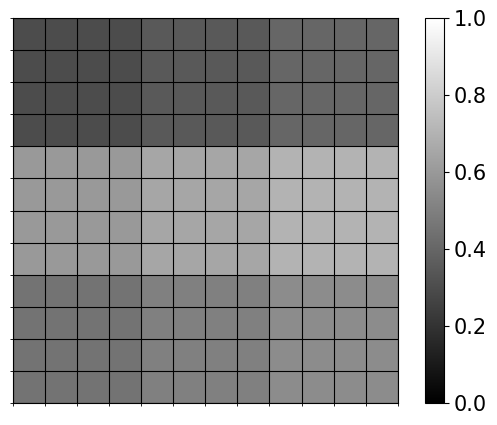

In [9]:
plt.rcParams.update({'font.size': 15})

xa = int(1/3 * N)

slice_ind = np.zeros((N, N))
slice_ind[0:xa, 0:xa] = 0
slice_ind[0:xa, xa:2*xa] = 1
slice_ind[0:xa, 2*xa:3*xa] = 2
slice_ind[xa:2*xa, 0:xa] = 3
slice_ind[xa:2*xa, xa:2*xa] = 4
slice_ind[xa:2*xa, 2*xa:3*xa] = 5
slice_ind[2*xa:3*xa, 0:xa] = 6
slice_ind[2*xa:3*xa, xa:2*xa] = 7
slice_ind[2*xa:3*xa, 2*xa:3*xa] = 8

f = np.array([0.3, 0.35, 0.4,
              0.6, 0.65, 0.7,
              0.45, 0.5, 0.55])

Vintra = np.zeros((N, N))
for vi in range(9):
    Vintra[slice_ind == vi] = f[vi]
    
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(Vintra, cmap="gray", vmin=0, vmax=1)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [10]:
DWI = fib3_phantom_9comps(gtab, N=N)

In [11]:
DWI_4D = np.zeros((N, N, 1, len(gtab.bvals)))

In [12]:
DWI_4D[:, :, 0, :] = DWI

In [13]:
csamodel = CsaOdfModel(gtab, 6)

In [14]:
csapeaks = peaks_from_model(model=csamodel,
                            data=DWI_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

In [15]:
#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

### Ground truth Phantom

Let first generate ground truth phantoms

In [16]:
# Ground truth for uncorrelated noise
DWI = fib3_phantom_9comps(gtab, N=N)

# Ground truth for correlated noise
if corrupt == 1:
    DWIc = smooth(DWI.copy(), gauss_std)
else:
    DWIc = zero_fill(DWI.copy(), zf)

m = DWI.shape[0] * DWI.shape[1]

Let's plot example image for the first direction of b-value=3000

In [17]:
v = 98
print("b-values for this experiement is b = {}".format(gtab.bvals[v]))
print("diffusion direction for this experiement is v = {}".format(gtab.bvecs[v]))

b-values for this experiement is b = 3000.0
diffusion direction for this experiement is v = [-0.08843536 -0.4336644   0.89672425]


Below, I am showing the ground truth phantom for spatially uncorrelated noise 

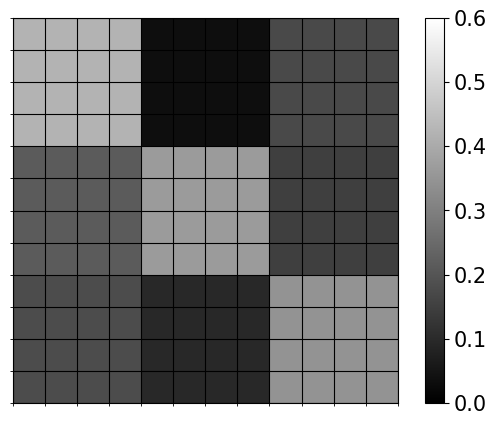

In [18]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWI[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

Below, I am showing the ground truth phantom for spatially correlated noise 

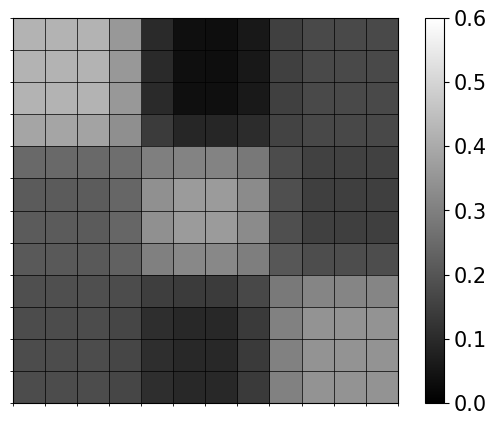

In [19]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWIc[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

# Add noise

In [20]:
sig2 = (1/snr) ** 2  

if gaussian:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
else:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')

if corrupt == 1:
    DWInc = smooth(DWIn, gauss_std)
if corrupt == 2:
    DWInc = zero_fill(DWIn.copy(), zf)

Let's plot an example noisy image for the selected direction for b-value=3000 (<ins>Spatially uncorrelated noise</ins>)

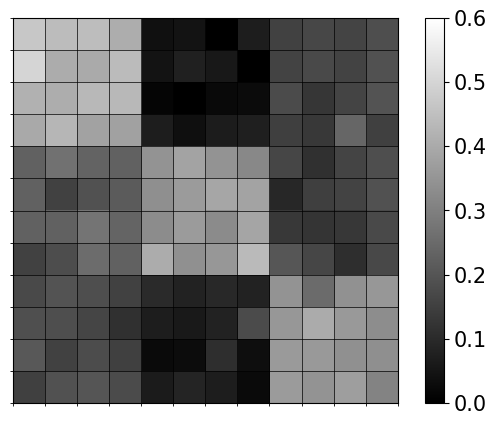

In [21]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWIn[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

Let's plot an example noisy image for the selected direction for b-value=3000 (<ins>Spatially correlated noise</ins>)

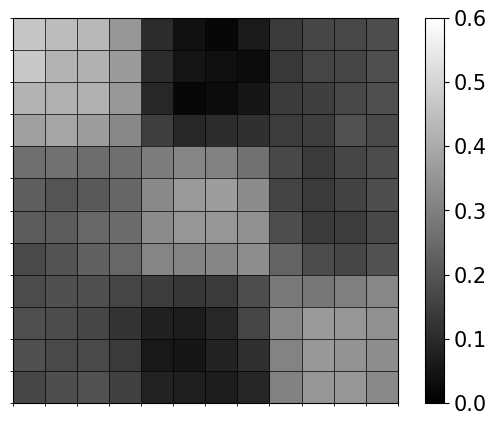

In [22]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWInc[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

# MPPCA Denoising

In [23]:
# Let's convert phantoms to a 2D matrix
n = DWIn.shape[-1]
m = DWIn.shape[0]*DWIn.shape[1]
y = n*1.0/m
X = DWIn.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
Xc = DWInc.reshape(m, n)
Mc = np.mean(Xc, axis=0)
Xc = Xc - Mc

In [24]:
# MP-PCA denoising
t = time()
Xd, ncomps = _pca_matrix(X)
tf = time() - t
print("Time taken for MPPCA ", tf)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

t = time()
Xdc, ncomps = _pca_matrix(Xc)
tf = time() - t
print("Time taken for MPPCA ", tf)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

Time taken for MPPCA  0.012480735778808594
102
Time taken for MPPCA  0.015635251998901367
8


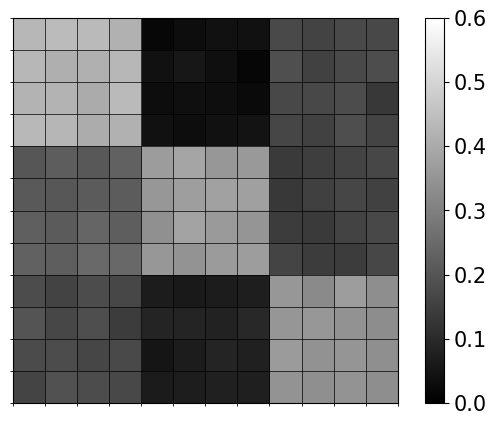

In [25]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWId[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

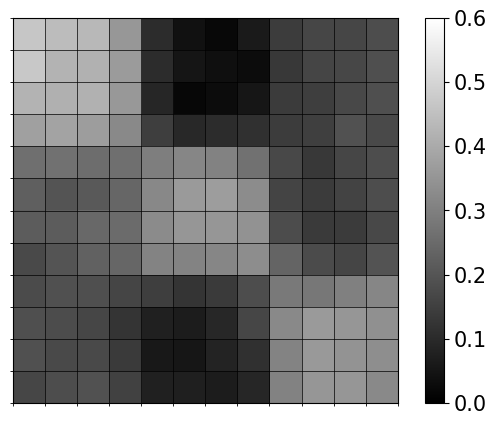

In [26]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWIdc[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

MP-PCA successfully suppresses noise when it is spatially uncorrelated but its performance is limited on spatially correlated noise.

# MPPCA slow

In [27]:
# MP-PCA denoising
t = time()
Xd, ncomps = _pca_matrix(X, mppca_slow=True)
tf = time() - t
print("Time taken for MPPCA ", tf)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

t = time()
Xdc, ncomps = _pca_matrix(Xc, mppca_slow=True)
tf = time() - t
print("Time taken for MPPCA ", tf)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

Time taken for MPPCA  0.24265241622924805
100
Time taken for MPPCA  1.024235486984253
13


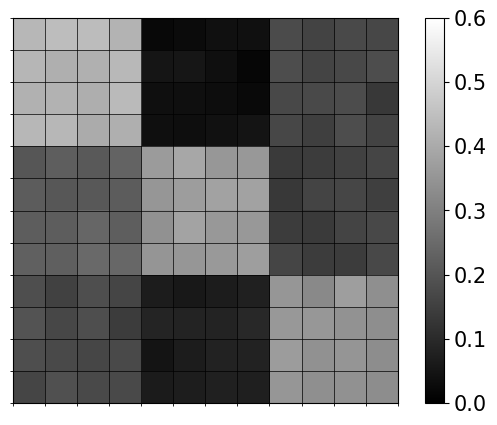

In [28]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWId[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

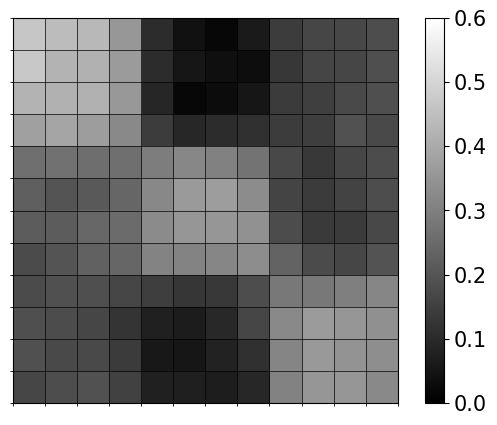

In [29]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWIdc[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

MPPCA slow provides a good denoising performance for uncorrelated and correlated noise, but requires much longer processing times.

# GPCA Denoising

In [30]:
# General PCA denoising
varp1 = np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))
varp2 = np.mean(np.var(DWInc[..., gtab.b0s_mask], axis=-1, ddof=1))

t = time()
Xd, ncomps = _pca_matrix(X, sig2=varp1)
tf = time() - t
print("Time taken for GPCA ", tf)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

t = time()
Xdc, ncomps = _pca_matrix(Xc, sig2=varp2)
tf = time() - t
print("Time taken for GPCA ", tf)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

Time taken for GPCA  0.023997783660888672
102
Time taken for GPCA  0.01899862289428711
102


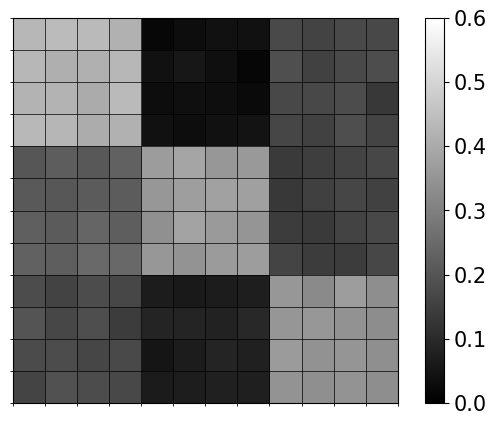

In [31]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWId[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

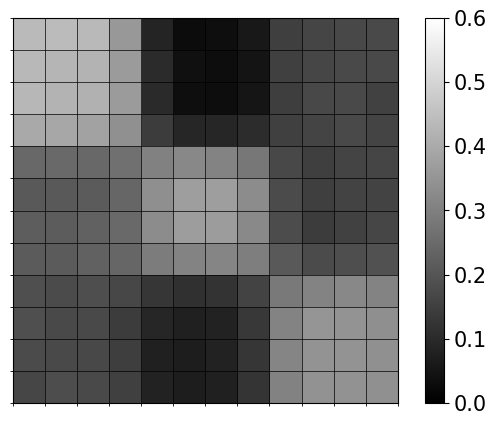

In [32]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWIdc[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

GPCA has an optimal performance for both spatially uncorrelated and correlated noise. For both cases, it correclty detected the 102 ground truth noise components of the phantoms.

# TPCA Denoising

In [33]:
t = time()
Xd, ncomps = _pca_matrix(X, sig2=varp1, tau_factor=1+np.sqrt(n / m))
tf = time() - t
print("Time taken for GPCA ", tf)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

t = time()
Xdc, ncomps = _pca_matrix(Xc, sig2=varp2, tau_factor=1+np.sqrt(n / m))
tf = time() - t
print("Time taken for GPCA ", tf)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

Time taken for GPCA  0.021860837936401367
102
Time taken for GPCA  0.01835775375366211
100


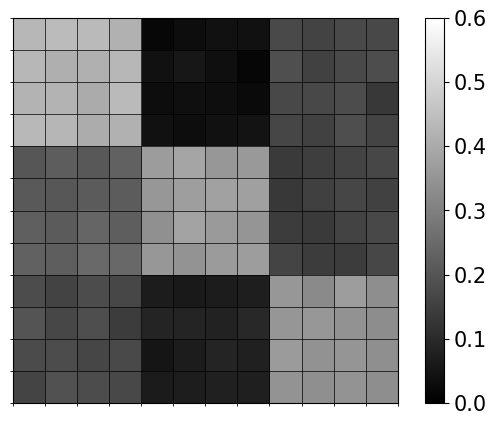

In [34]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWId[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

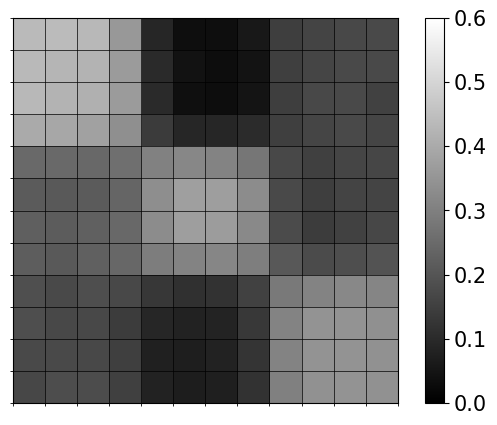

In [35]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(DWIdc[:, :, v], cmap="gray", vmin=0, vmax=0.6)
#plt.title("S/S0", fontsize=15)
plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

TPCA denoising also provides robust denoising for both spatially uncorrelated and correlated phantoms. However, it perserved 2 more signal components than expected.

# Analyse eigenvalues (uncorrelated noise corrupted)

In [36]:
n = DWIn.shape[-1]
m = DWIn.shape[0]*DWIn.shape[1]
y = n*1.0/m
X = DWIn.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

Compute mean eigenvalue for different sets of lower eigenvalues

In [37]:
mL = L.copy()
for ii in range(L.size):
    mL[ii] = np.mean(L[:ii+1])
    
# This is just in case you want to check that mL is the same of the mL evaluated by algorithms

Compute the two different variances evaluated by MP-PCA denoising algorithm for the different sets of lower eigenvalues

In [38]:
sig2_m, sig2_w = _pca_classifier_code2(L.copy(), m)

Compute noise level prior

In [39]:
varmeasured = np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))

Compute the number of components classified as noise by MP-PCA, GPCA and TPCA

In [40]:
var_mpca, ncomp_mpca = _pca_classifier(L.copy(), m)
var_mpca_slow, ncomp_mpca_slow = _pca_classifier_slow(L.copy(), m)
var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), varmeasured)
var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), varmeasured, tau_factor=1+np.sqrt(n / m))
print(ncomp_mpca)
print(ncomp_mpca_slow)
print(ncomp_gpca)
print(ncomp_tpca)

102
100
102
102


Plot results

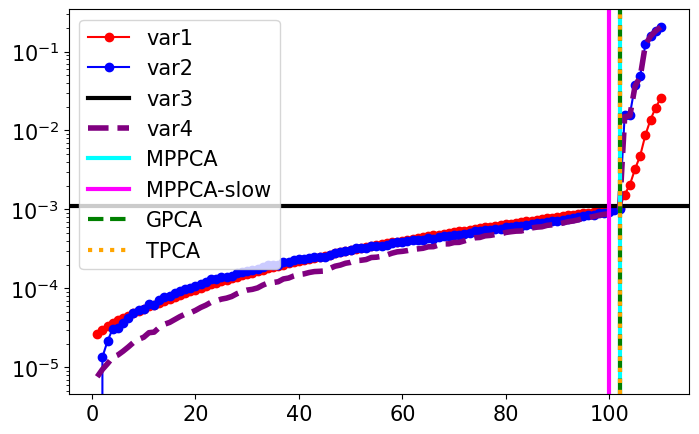

In [41]:
nc = np.arange(1, n+1)

fig = plt.figure(figsize=(8, 5))
plt.plot(nc, sig2_m, 'o-', color='red', label='var1')
plt.plot(nc, sig2_w, 'o-', color='blue', label='var2')
plt.axhline(varmeasured, color='black', label='var3', linewidth=3)
plt.plot(nc, L/((1+np.sqrt(y))**2), linestyle='dashed', color='purple', label='var4', linewidth=4)
plt.yscale('log')

plt.axvline(ncomp_mpca, color='cyan', linewidth=3, label='MPPCA') #, linestyle='dashed')
plt.axvline(ncomp_mpca_slow, color='magenta', linewidth=3, label='MPPCA-slow') #, linestyle='dashed')
plt.axvline(ncomp_gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.axvline(ncomp_tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.legend(loc=0, prop={'size': 15})

(0.00030000000000000003, 0.3)

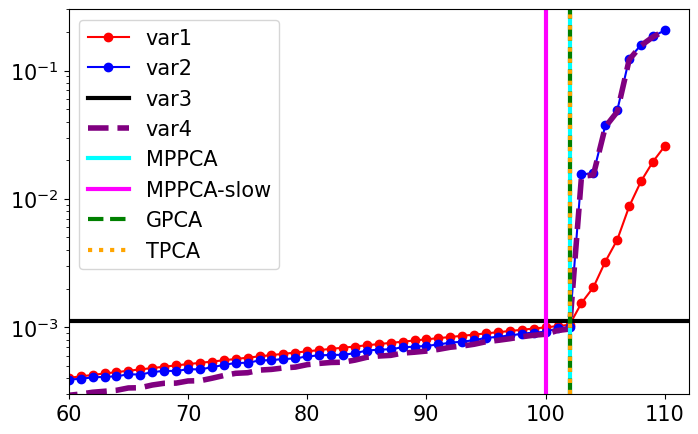

In [42]:
nc = np.arange(1, n+1)

fig = plt.figure(figsize=(8, 5))
plt.plot(nc, sig2_m, 'o-', color='red', label='var1')
plt.plot(nc, sig2_w, 'o-', color='blue', label='var2')
plt.axhline(varmeasured, color='black', label='var3', linewidth=3)
plt.plot(nc, L/((1+np.sqrt(y))**2), linestyle='dashed', color='purple', label='var4', linewidth=4)
plt.yscale('log')

plt.axvline(ncomp_mpca, color='cyan', linewidth=3, label='MPPCA') #, linestyle='dashed')
plt.axvline(ncomp_mpca_slow, color='magenta', linewidth=3, label='MPPCA-slow') #, linestyle='dashed')
plt.axvline(ncomp_gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.axvline(ncomp_tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.legend(loc=0, prop={'size': 15})

plt.xlim([60, 112])
plt.ylim([3*10**-4, 0.3])

### Analyse number of componet preserved as function of variance overestimation

In [43]:
#sig = (1/snr)
sig = np.sqrt(varmeasured)
overest = np.arange(-25, 405, 5)  # STD overestimation in percentage

In [44]:
ncomps_tpca = np.zeros(overest.shape)
ncomps_gpca = np.zeros(overest.shape)
for overi, overv in enumerate(overest):
    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), (sig * (overv*0.01+1)) ** 2)
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), ((sig * (overv*0.01+1)) ** 2), tau_factor=1+np.sqrt(n / m))
    ncomps_tpca[overi] = ncomp_tpca
    ncomps_gpca[overi] = ncomp_gpca

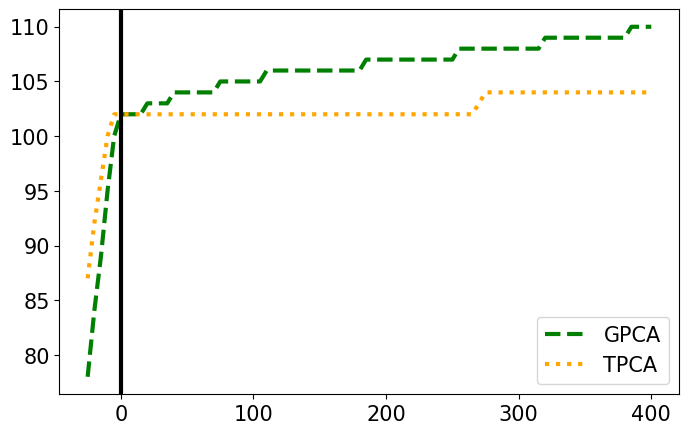

In [45]:
fig = plt.figure(figsize=(8, 5))
plt.plot(overest, ncomps_gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.plot(overest, ncomps_tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.axvline(0, color='black', linewidth=3) #, linestyle='dashed')
plt.legend(loc=0, prop={'size': 15})

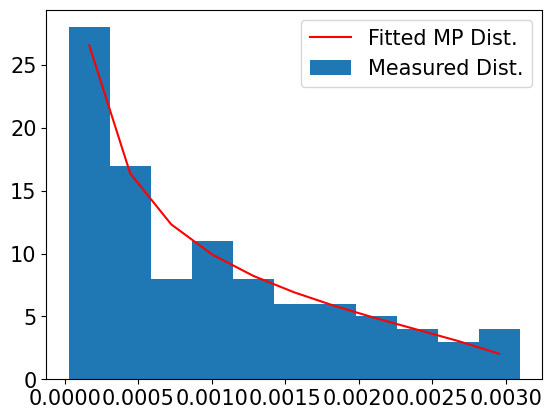

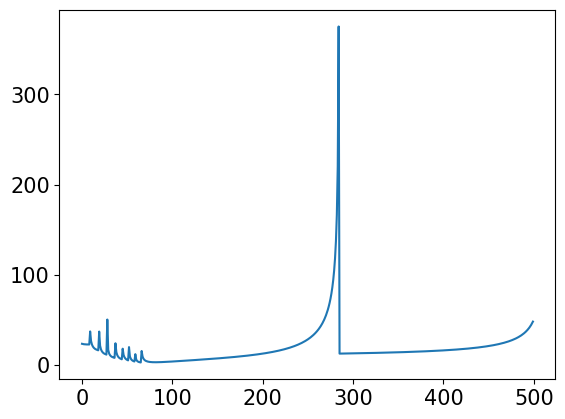

[65]
65


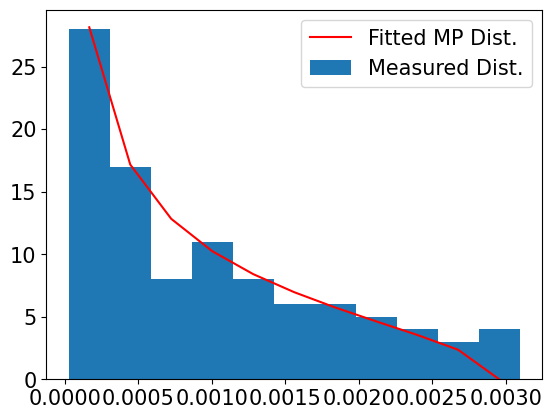

11


In [46]:
var, ncomps, nb = _pca_classifier_slow_plot(L, ncomp_mpca_slow, m)
print(nb)

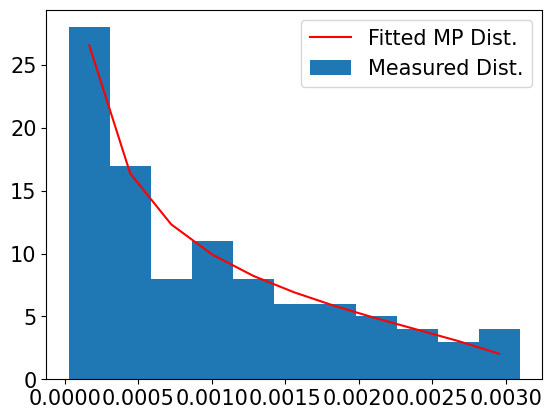

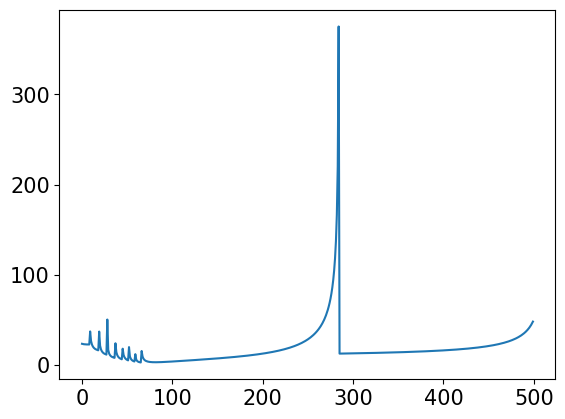

[65]
65


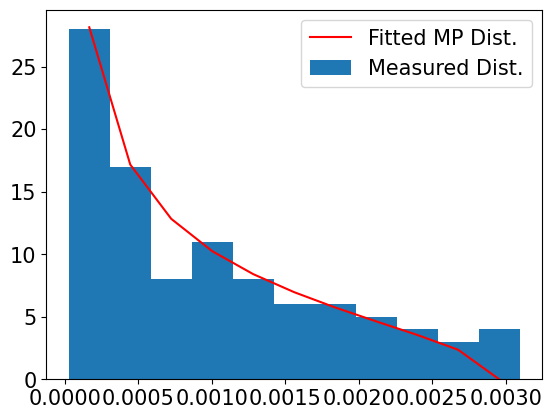

97
11


In [47]:
var, ncomps, nb = _pca_classifier_slow_plot(L, ncomp_mpca_slow, m)
print(ncomps)
print(nb)

# Analyse eigenvalues (correlated noise corrupted)

In [63]:
n = DWInc.shape[-1]
m = DWInc.shape[0]*DWIn.shape[1]
y = n*1.0/m
X = DWInc.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

Compute mean eigenvalue for different sets of lower eigenvalues

In [64]:
mL = L.copy()
for ii in range(L.size):
    mL[ii] = np.mean(L[:ii+1])
    
# This is just in case you want to check that mL is the same of the mL evaluated by algorithms

Compute the two different variances evaluated by MP-PCA denoising algorithm for the different sets of lower eigenvalues

In [65]:
sig2_m, sig2_w = _pca_classifier_code2(L.copy(), m)

Compute variance prior

In [66]:
varmeasured = np.mean(np.var(DWInc[..., gtab.b0s_mask], axis=-1, ddof=1))

Compute the number of components classified as noise by MP-PCA, TPCA, GPCA

In [67]:
var_mpca, ncomp_mpca = _pca_classifier(L.copy(), m)
var_mpca_slow, ncomp_mpca_slow = _pca_classifier_slow(L.copy(), m)
var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), varmeasured)
var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), varmeasured, tau_factor=1+np.sqrt(n / m))
print(ncomp_mpca)
print(ncomp_mpca_slow)
print(ncomp_gpca)
print(ncomp_tpca)

8
13
102
100


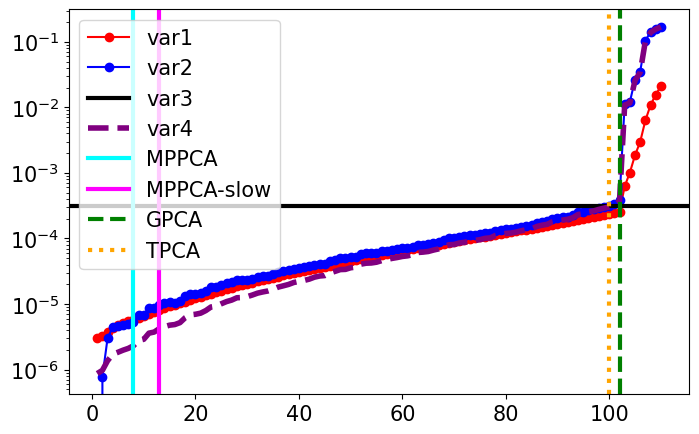

In [68]:
nc = np.arange(1, n+1)

fig = plt.figure(figsize=(8, 5))
plt.plot(nc, sig2_m, 'o-', color='red', label='var1')
plt.plot(nc, sig2_w, 'o-', color='blue', label='var2')
plt.axhline(varmeasured, color='black', label='var3', linewidth=3)
plt.plot(nc, L/((1+np.sqrt(y))**2), linestyle='dashed', color='purple', label='var4', linewidth=4)
plt.yscale('log')

plt.axvline(ncomp_mpca, color='cyan', linewidth=3, label='MPPCA') #, linestyle='dashed')
plt.axvline(ncomp_mpca_slow, color='magenta', linewidth=3, label='MPPCA-slow') #, linestyle='dashed')
plt.axvline(ncomp_gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.axvline(ncomp_tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.legend(loc=0, prop={'size': 15})

(0.0001, 0.3)

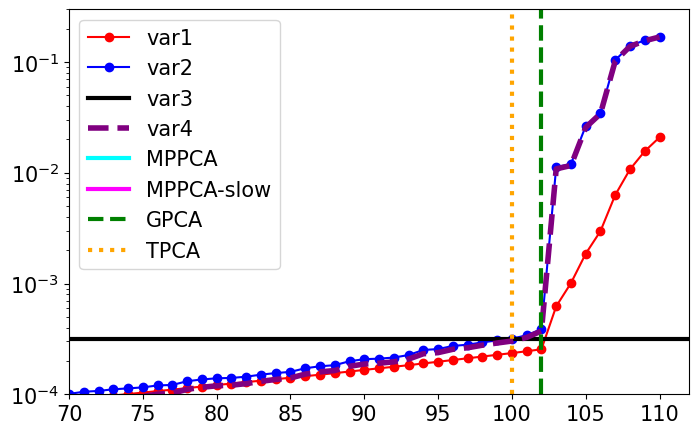

In [69]:
nc = np.arange(1, n+1)

fig = plt.figure(figsize=(8, 5))
plt.plot(nc, sig2_m, 'o-', color='red', label='var1')
plt.plot(nc, sig2_w, 'o-', color='blue', label='var2')
plt.axhline(varmeasured, color='black', label='var3', linewidth=3)
plt.plot(nc, L/((1+np.sqrt(y))**2), linestyle='dashed', color='purple', label='var4', linewidth=4)
plt.yscale('log')

plt.axvline(ncomp_mpca, color='cyan', linewidth=3, label='MPPCA') #, linestyle='dashed')
plt.axvline(ncomp_mpca_slow, color='magenta', linewidth=3, label='MPPCA-slow') #, linestyle='dashed')
plt.axvline(ncomp_gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.axvline(ncomp_tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.legend(loc=0, prop={'size': 15})

plt.xlim([70, 112])
plt.ylim([10**-4, 0.3])

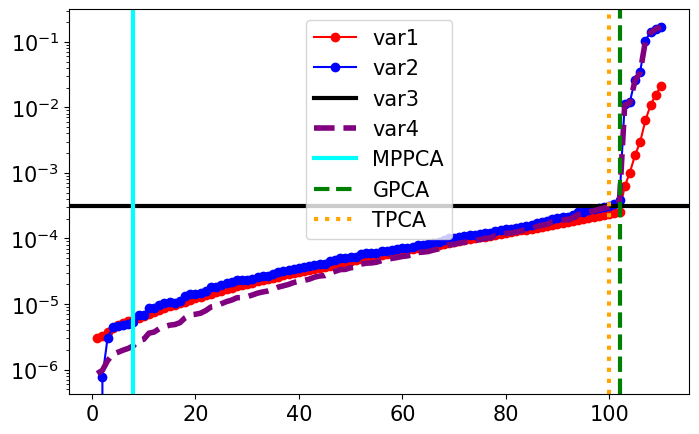

In [72]:
nc = np.arange(1, n+1)

fig = plt.figure(figsize=(8, 5))
plt.plot(nc, sig2_m, 'o-', color='red', label='var1')
plt.plot(nc, sig2_w, 'o-', color='blue', label='var2')
plt.axhline(varmeasured, color='black', label='var3', linewidth=3)
plt.plot(nc, L/((1+np.sqrt(y))**2), linestyle='dashed', color='purple', label='var4', linewidth=4)
plt.yscale('log')

plt.axvline(ncomp_mpca, color='cyan', linewidth=3, label='MPPCA') #, linestyle='dashed')
#plt.axvline(ncomp_mpca_slow, color='magenta', linewidth=3, label='MPPCA-slow') #, linestyle='dashed')
plt.axvline(ncomp_gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.axvline(ncomp_tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.legend(loc=9, prop={'size': 15})

(0.0001, 0.3)

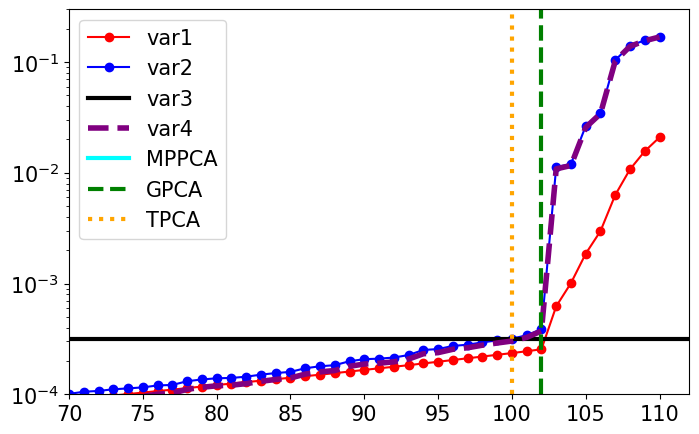

In [71]:
nc = np.arange(1, n+1)

fig = plt.figure(figsize=(8, 5))
plt.plot(nc, sig2_m, 'o-', color='red', label='var1')
plt.plot(nc, sig2_w, 'o-', color='blue', label='var2')
plt.axhline(varmeasured, color='black', label='var3', linewidth=3)
plt.plot(nc, L/((1+np.sqrt(y))**2), linestyle='dashed', color='purple', label='var4', linewidth=4)
plt.yscale('log')

plt.axvline(ncomp_mpca, color='cyan', linewidth=3, label='MPPCA') #, linestyle='dashed')
#plt.axvline(ncomp_mpca_slow, color='magenta', linewidth=3, label='MPPCA-slow') #, linestyle='dashed')
plt.axvline(ncomp_gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.axvline(ncomp_tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.legend(loc=0, prop={'size': 15})

plt.xlim([70, 112])
plt.ylim([10**-4, 0.3])

### Analyse number of componet preserved as function of variance overestimation

In [56]:
#sig = (1/snr)
sig = np.sqrt(varmeasured)
overest = np.arange(-25, 405, 5)  # STD overestimation in percentage

In [57]:
ncomps_tpca = np.zeros(overest.shape)
ncomps_gpca = np.zeros(overest.shape)
for overi, overv in enumerate(overest):
    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), (sig * (overv*0.01+1)) ** 2)
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), ((sig * (overv*0.01+1)) ** 2), tau_factor=1+np.sqrt(n / m))
    ncomps_tpca[overi] = ncomp_tpca
    ncomps_gpca[overi] = ncomp_gpca

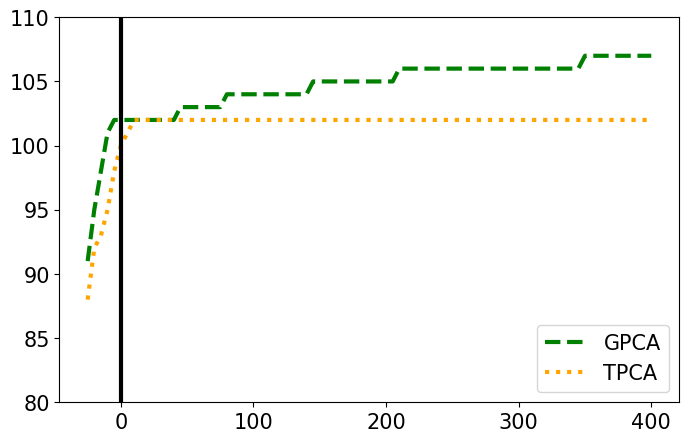

In [58]:
fig = plt.figure(figsize=(8, 5))
plt.plot(overest, ncomps_gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.plot(overest, ncomps_tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.axvline(0, color='black', linewidth=3) #, linestyle='dashed')
plt.ylim([80, 110])
plt.legend(loc=0, prop={'size': 15})

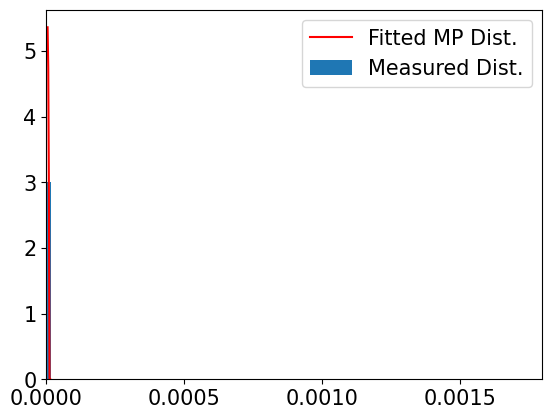

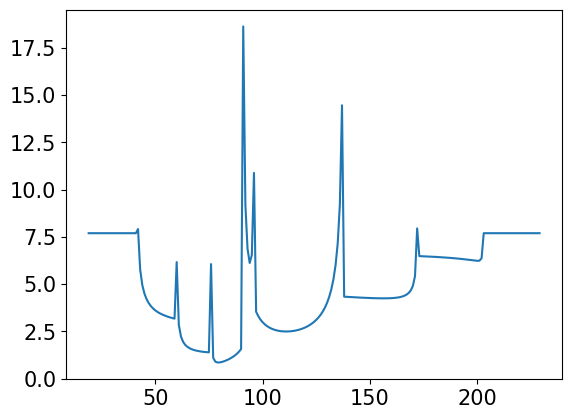

[79]
79


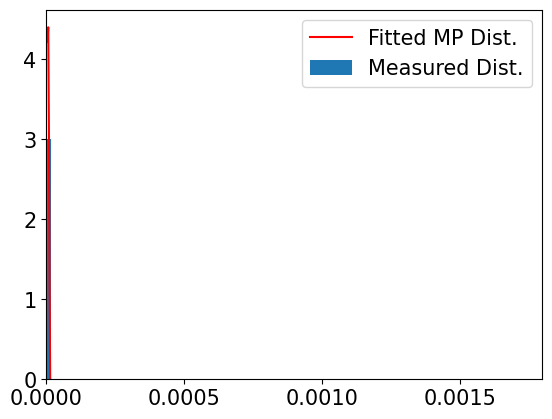

5
10


In [59]:
var, ncomps, nb = _pca_classifier_slow_plot(L, ncomp_mpca_slow, m, xlim=[0, 0.0018])
print(nb)
print(ncomps)

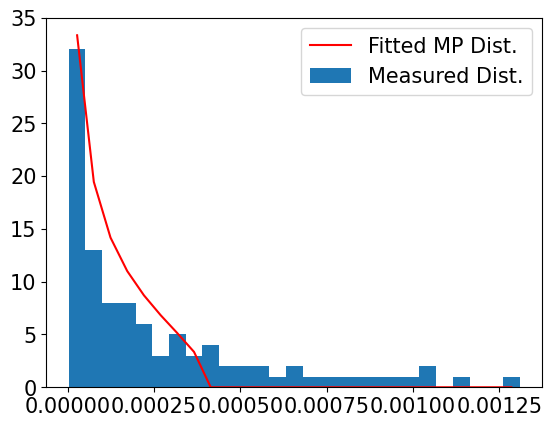

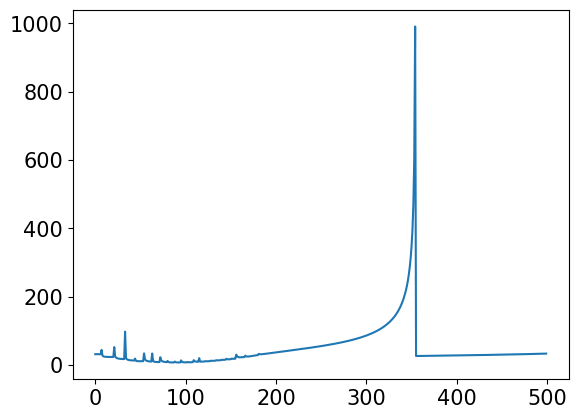

[92]
92


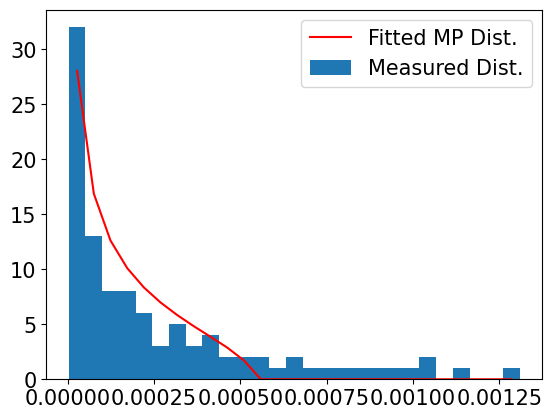

86
27


In [60]:
var, ncomps, nb = _pca_classifier_slow_plot(L, 102, m)
print(ncomps)
print(nb)

# Histograms of eigenvalues for 1000 repetitions

In [73]:
# spatially uncorrelated noise

nrep = 1000
eig = np.zeros((nrep, L.size))
max_eig = np.zeros(nrep)
min_eig = np.zeros(nrep)
mean_eig = np.zeros(nrep)
eig_tpca = np.zeros(nrep)
eig_gpca = np.zeros(nrep)
eig_mppca = np.zeros(nrep)
eig_mppca_slow = np.zeros(nrep)
var_all = np.zeros(nrep)
n_tpca = np.zeros(nrep)
n_gpca = np.zeros(nrep)
n_mppca = np.zeros(nrep)
n_mppca_slow = np.zeros(nrep)
time_mpca = 0
time_mpca_slow = 0
time_tpca = 0
time_gpca = 0

for rep in range(nrep):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')
    
    #if corrupt == 1:
    #    DWIn = smooth(DWIn.copy(), gauss_std)
    var_all[rep] = np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))

    X = DWIn.reshape(m, n)
    M = np.mean(X, axis=0)
    X = X - M
    [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
    eig[rep, :] = L
    
    t0 = time()
    var_mpca, ncomp_mpca = _pca_classifier(L.copy(), m)
    time_mpca = time_mpca + time() - t0
    
    t0 = time()
    var_mpca_slow, ncomp_mpca_slow = _pca_classifier_slow(L.copy(), m)
    time_mpca_slow = time_mpca_slow + time() - t0
    
    t0 = time()
    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_all[rep])
    time_gpca = time_gpca + time() - t0
    
    t0 = time()
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_all[rep], tau_factor=1+np.sqrt(n / m))
    time_tpca = time_tpca + time() - t0
    
    # ncomp -1 because index start from 0
    eig_tpca[rep] = L[ncomp_tpca - 1]
    eig_gpca[rep] = L[ncomp_gpca - 1]
    eig_mppca[rep] = L[ncomp_mpca - 1]
    eig_mppca_slow[rep] = L[ncomp_mpca_slow - 1]
    
    n_tpca[rep] = ncomp_tpca
    n_gpca[rep] = ncomp_gpca
    n_mppca[rep] = ncomp_mpca
    n_mppca_slow[rep] = ncomp_mpca_slow
    
    max_eig[rep] = np.max(L[:-8])
    min_eig[rep] = np.min(L[:-8])
    mean_eig[rep] = np.mean(L[:-8])
    print(rep)
    
measuredvar = np.mean(var_all)
mmax_eig = np.mean(max_eig)
mmin_eig = np.mean(min_eig)
mmean_eig = np.mean(mean_eig)

mpca = np.median(eig_mppca)
mpca_slow = np.median(eig_mppca_slow)
gpca = np.median(eig_gpca)
tpca = np.median(eig_tpca)

print(time_mpca)
print(time_mpca_slow)
print(time_gpca)
print(time_tpca)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

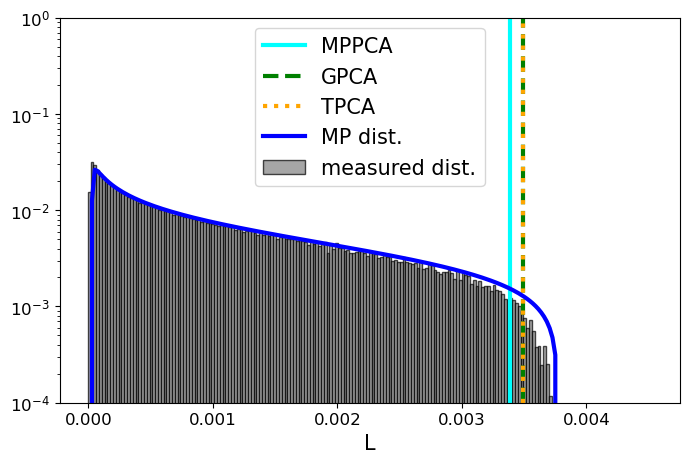

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [74]:
eigl = eig[:, :-8]  # remove the signal components

y = 102/m

rpos = 1.2 * measuredvar * (1 + np.sqrt(y)) ** 2
rneg = (measuredvar * (1 - np.sqrt(y)) ** 2) / 4

x = np.linspace(rneg, rpos, num=200)
p = mp_distribution(x, measuredvar, y)
upper_b = measuredvar * (1 + np.sqrt(y)) ** 2
lower_b = measuredvar * (1 - np.sqrt(y)) ** 2

beig, ed = np.histogram(eigl.flat, bins = 200, range=(rneg, rpos))
beig = beig / np.sum(beig)

fig = plt.figure(figsize=(8, 5))
plt.bar(ed[:-1], beig, width = (rneg-rpos)/200, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

plt.axvline(mpca, color='cyan', linewidth=3, label='MPPCA') #, linestyle='dashed')
#plt.axvline(mpca_slow, color='magenta', linewidth=3, label='MPPCA-slow')
plt.axvline(gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.axvline(tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.plot(x, p, color=[0, 0, 1], label='MP dist.', linewidth=3)

plt.legend(loc=0, prop={'size': 15})

plt.xlabel('L', fontsize=15)
plt.yscale('log')
plt.ylim([10**-4, 1])

ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
plt.show()

fig.savefig('multi_sim_dist.eps')

602.0
513.0
991.0
991.0


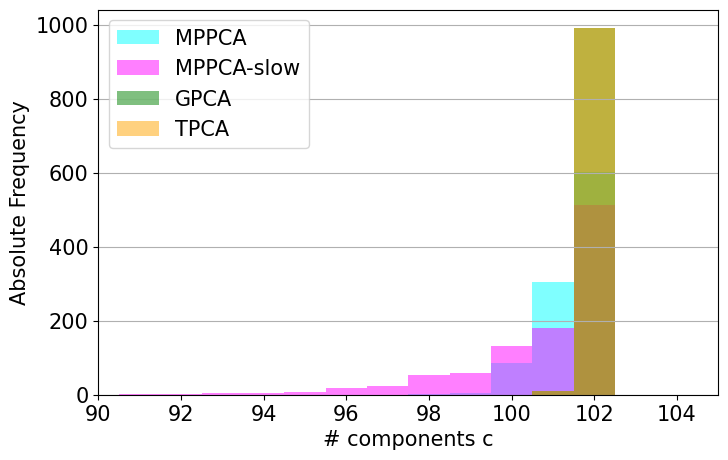

In [75]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(8, 5))

bins = np.arange(0, 110, 1) - 0.5

nnn, bins, patches = plt.hist(x=n_mppca, bins=bins, color='cyan', label='MPPCA',
                              alpha=0.5, rwidth=1)
print(nnn[102])
nnn, bins, patches = plt.hist(x=n_mppca_slow, bins=bins, color='magenta', label='MPPCA-slow',
                              alpha=0.5, rwidth=1)
print(nnn[102])
nnn, bins, patches = plt.hist(x=n_gpca, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1)
print(nnn[102])
nnn, bins, patches = plt.hist(x=n_tpca, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1)

plt.legend(loc=0, prop={'size': 15})
print(nnn[102])
plt.grid(axis='y', alpha=1)
plt.xlim([90, 105])
plt.xlabel('# components c')
plt.ylabel('Absolute Frequency')
maxfreq = nnn.max()

In [ ]:
# spatially correlated noise

nrep = 1000
eig = np.zeros((nrep, L.size))
max_eig = np.zeros(nrep)
min_eig = np.zeros(nrep)
mean_eig = np.zeros(nrep)
eig_tpca = np.zeros(nrep)
eig_gpca = np.zeros(nrep)
eig_mppca = np.zeros(nrep)
eig_mppca_slow = np.zeros(nrep)
var_all = np.zeros(nrep)
n_tpca = np.zeros(nrep)
n_gpca = np.zeros(nrep)
n_mppca = np.zeros(nrep)
n_mppca_slow = np.zeros(nrep)
time_mpca = 0
time_mpca_slow = 0
time_tpca = 0
time_gpca = 0

for rep in range(nrep):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')
    
    if corrupt == 1:
        DWIn = smooth(DWIn.copy(), gauss_std)
    else:
        DWIn = zero_fill(DWIn.copy(), zf)
    var_all[rep] = np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))

    X = DWIn.reshape(m, n)
    M = np.mean(X, axis=0)
    X = X - M
    [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
    eig[rep, :] = L
    
    t0 = time()
    var_mpca, ncomp_mpca = _pca_classifier(L.copy(), m)
    time_mpca = time_mpca + time() - t0
    
    t0 = time()
    var_mpca_slow, ncomp_mpca_slow = _pca_classifier_slow(L.copy(), m)
    time_mpca_slow = time_mpca_slow + time() - t0
    
    t0 = time()
    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_all[rep])
    time_gpca = time_gpca + time() - t0
    
    t0 = time()
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_all[rep], tau_factor=1+np.sqrt(n / m))
    time_tpca = time_tpca + time() - t0
    
    # ncomp -1 because index start from 0
    eig_tpca[rep] = L[ncomp_tpca - 1]
    eig_gpca[rep] = L[ncomp_gpca - 1]
    eig_mppca[rep] = L[ncomp_mpca - 1]
    eig_mppca_slow[rep] = L[ncomp_mpca_slow - 1]
    
    n_tpca[rep] = ncomp_tpca
    n_gpca[rep] = ncomp_gpca
    n_mppca[rep] = ncomp_mpca
    n_mppca_slow[rep] = ncomp_mpca_slow
    
    max_eig[rep] = np.max(L[:-8])
    min_eig[rep] = np.min(L[:-8])
    mean_eig[rep] = np.mean(L[:-8])
    print(rep)
    
measuredvar = np.mean(var_all)
mmax_eig = np.mean(max_eig)
mmin_eig = np.mean(min_eig)
mmean_eig = np.mean(mean_eig)

mpca = np.median(eig_mppca)
mpca_slow = np.median(eig_mppca_slow)
gpca = np.median(eig_gpca)
tpca = np.median(eig_tpca)

print(time_mpca)
print(time_mpca_slow)
print(time_gpca)
print(time_tpca)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\rafae\AppData\Local\Temp\ipykernel_3652\1841583061.py:129: RuntimeWarning: divide by zero encountered in scalar divide
  nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)


664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865


In [ ]:
eigl = eig[:, :-1]  # remove the signal components
y = 102/m

rpos = 1.2 * measuredvar * (1 + np.sqrt(y)) ** 2
rneg = (measuredvar * (1 - np.sqrt(y)) ** 2) / 4

x = np.linspace(rneg, rpos, num=200)
p = mp_distribution(x, measuredvar, y)
upper_b = measuredvar * (1 + np.sqrt(y)) ** 2
lower_b = measuredvar * (1 - np.sqrt(y)) ** 2

beig, ed = np.histogram(eigl.flat, bins = 200, range=(rneg, rpos))
beig = beig / np.sum(beig)

fig = plt.figure(figsize=(8, 5))
plt.bar(ed[:-1], beig, width = (rneg-rpos)/200, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

plt.axvline(mpca, color='cyan', linewidth=3, label='MPPCA') #, linestyle='dashed')
#plt.axvline(mpca_slow, color='magenta', linewidth=3, label='MPPCA-slow')
plt.axvline(gpca, color='green', linewidth=3, linestyle='dashed', label='GPCA')
plt.axvline(tpca, color='orange', linewidth=3, linestyle=':', label='TPCA')
plt.plot(x, p, color=[0, 0, 1], label='MP dist.', linewidth=3)

plt.legend(loc=0, prop={'size': 15})

plt.xlabel('L', fontsize=15)
plt.yscale('log')
plt.ylim([10**-4, 1])

ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
plt.show()


fig.savefig('multi_sim_dist.eps')

In [ ]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(8, 5))

bins = np.arange(0, 110, 1) - 0.5

nnn, bins, patches = plt.hist(x=n_mppca, bins=bins, color='cyan', label='MPPCA',
                              alpha=0.5, rwidth=1)
print(nnn[102])
nnn, bins, patches = plt.hist(x=n_mppca_slow, bins=bins, color='magenta', label='MPPCA-slow',
                              alpha=0.5, rwidth=1)
print(nnn[102])
nnn, bins, patches = plt.hist(x=n_gpca, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1)
print(nnn[102])
nnn, bins, patches = plt.hist(x=n_tpca, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1)
print(nnn[102])
plt.grid(axis='y', alpha=1)
plt.xlim([90, 105])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})